In [46]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


datadir='/mnt/f/Tirocinio_HDD/Data/ADNI/UNIQUE_FILE.xlsx'
data=pd.read_excel(datadir)
data=data[data.columns[data.columns.isin(['ABETA','PTAU','TAU','A_COMPOSITE_SUVR','A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]]
data[data < 0] = 0
datanoage=data

In [47]:
len(data.columns) #check 18

18

In [48]:
# preprocessing step, all -99 values set to 0

data

,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
0,562.6,299.7,30.43,0.0000,0.000000,0.000000,0.000000,0.000000,1.329950,1.148381,1.409114,1.621943,1.351061,0.951459,0.001999,0.000832,0.001200,0.003219
1,688.9,394.0,40.35,1.8664,1.100889,0.613641,0.703225,0.666256,1.493576,1.308446,1.710615,1.790227,1.531171,1.042618,0.001760,0.000655,0.000469,0.003433
2,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
3,866.2,335.9,33.43,1.8596,1.236018,0.710368,0.825823,0.796569,1.634722,2.383952,1.466140,1.295301,1.307511,0.790032,0.002673,0.001198,0.001332,0.002352
4,599.9,319.6,31.80,1.5173,1.122191,0.696962,0.821196,0.716009,1.376690,1.174672,1.455197,1.685974,1.291726,1.111146,0.001984,0.000700,0.000865,0.003004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,1422.0,231.5,19.86,0.0000,0.000000,0.000000,0.000000,0.000000,1.177743,1.071711,1.165383,1.240425,1.269879,1.444825,0.002522,0.000903,0.001250,0.004186
487,1307.0,176.4,15.17,0.0000,0.000000,0.000000,0.000000,0.000000,1.138416,1.025719,1.048725,1.305480,1.325122,0.000000,0.002492,0.001225,0.001259,0.004262
488,616.3,400.4,39.71,0.0000,0.000000,0.000000,0.000000,0.000000,1.140999,1.049048,1.143526,1.220449,1.185020,0.000000,0.002727,0.001033,0.001008,0.005010
489,1927.0,217.8,19.95,0.0000,0.000000,0.000000,0.000000,0.000000,1.102459,1.057882,1.018764,1.157956,1.202269,1.206199,0.003112,0.001050,0.001128,0.004469


For n_clusters = 3 The average silhouette_score is : 0.561990389030965
For n_clusters = 4 The average silhouette_score is : 0.5097619818822159
For n_clusters = 5 The average silhouette_score is : 0.4997108631472385


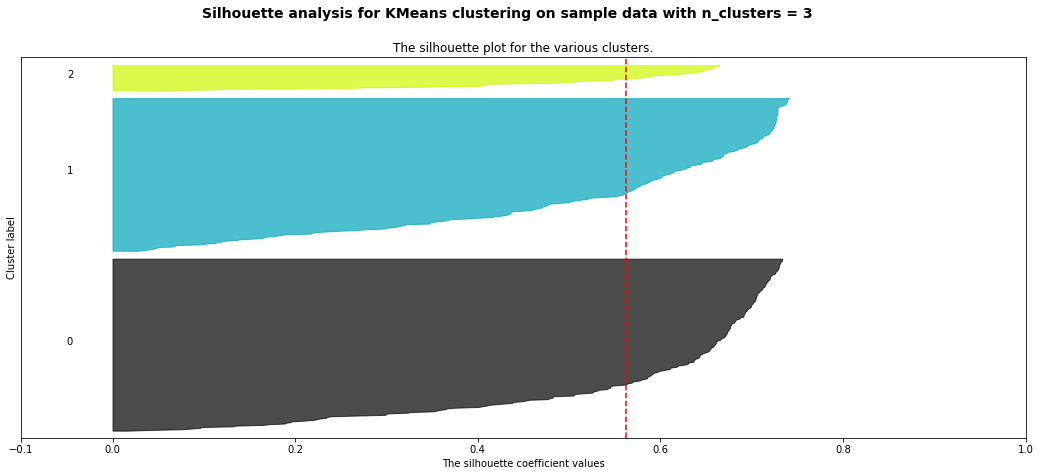

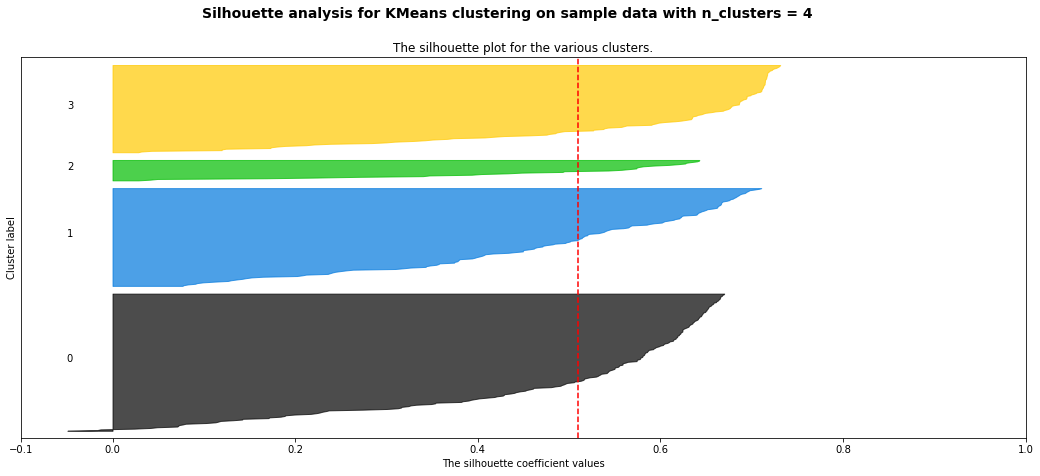

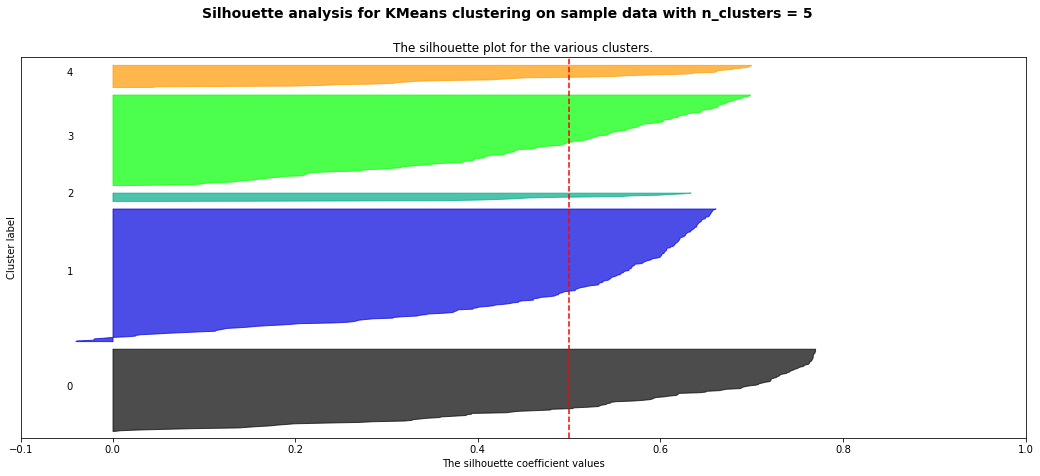

In [49]:
range_n_clusters = [3, 4, 5]
X=data

for n_clusters in range_n_clusters:
 
    fig, (ax1) = plt.subplots(1,1 )
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])



    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=None).fit(X)
    cluster_labels=kmeans.labels_
    centers= kmeans.cluster_centers_
    
   # cluster_labels = KMeans(n_clusters=n_clusters, random_state=None).fit_predict(X) #equivalent to calling fit(X) and after predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
   
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )


plt.savefig('My_silhouette.png')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.561990389030965
For n_clusters = 4 The average silhouette_score is : 0.509446608454951
For n_clusters = 5 The average silhouette_score is : 0.49460995778772426


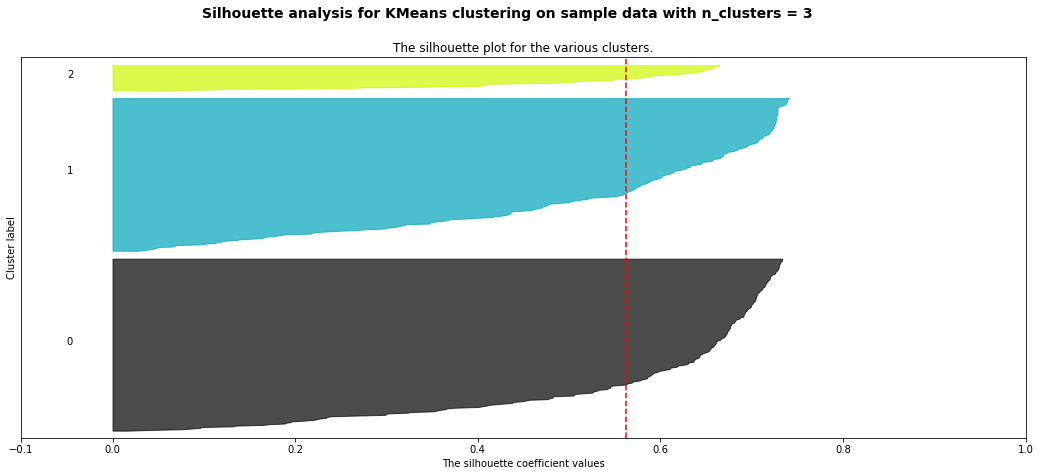

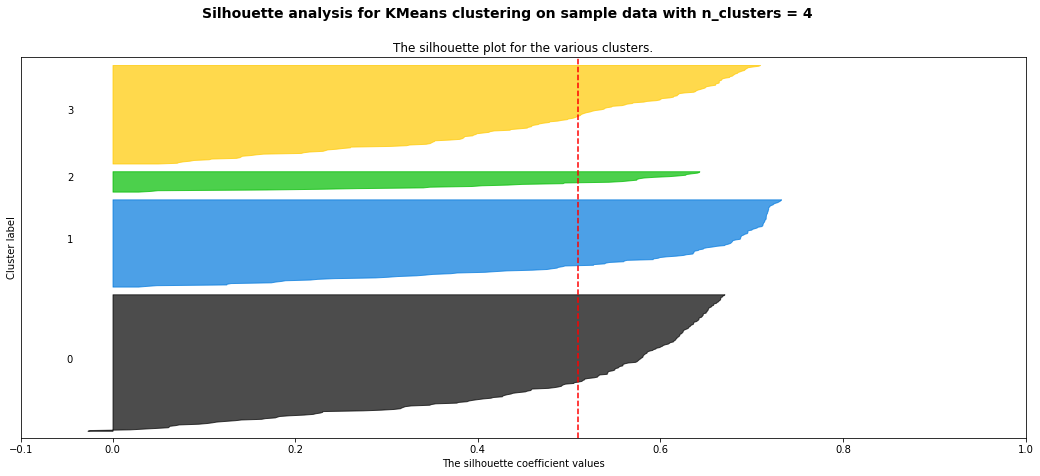

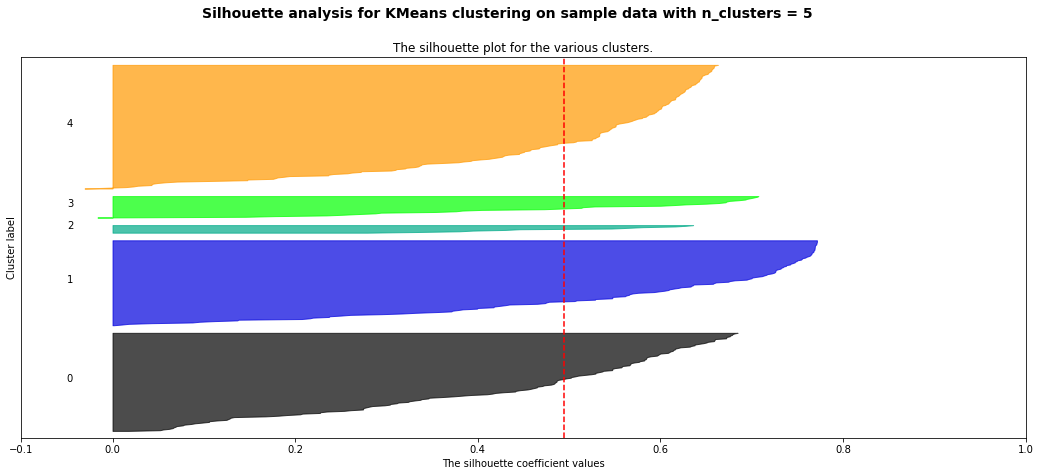

In [11]:
### MY IMPL

range_n_clusters = [3, 4, 5]
X=data

for n_clusters in range_n_clusters:
 
    fig, (ax1) = plt.subplots(1,1 )
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])



    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #kmeans = KMeans(n_clusters=n_clusters, random_state=None).fit(X)
    #cluster_labels=kmeans.labels_
    #centers= kmeans.cluster_centers_
    
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=None).fit_predict(X) #equivalent to calling fit(X) and after predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )


plt.savefig('SKlearn_silhpuette.png')
plt.show()

In [7]:
X

,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
0,562.6,299.7,30.43,0.0000,0.000000,0.000000,0.000000,0.000000,1.329950,1.148381,1.409114,1.621943,1.351061,0.951459,0.001999,0.000832,0.001200,0.003219
1,688.9,394.0,40.35,1.8664,1.100889,0.613641,0.703225,0.666256,1.493576,1.308446,1.710615,1.790227,1.531171,1.042618,0.001760,0.000655,0.000469,0.003433
2,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
3,866.2,335.9,33.43,1.8596,1.236018,0.710368,0.825823,0.796569,1.634722,2.383952,1.466140,1.295301,1.307511,0.790032,0.002673,0.001198,0.001332,0.002352
4,599.9,319.6,31.80,1.5173,1.122191,0.696962,0.821196,0.716009,1.376690,1.174672,1.455197,1.685974,1.291726,1.111146,0.001984,0.000700,0.000865,0.003004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,1422.0,231.5,19.86,0.0000,0.000000,0.000000,0.000000,0.000000,1.177743,1.071711,1.165383,1.240425,1.269879,1.444825,0.002522,0.000903,0.001250,0.004186
487,1307.0,176.4,15.17,0.0000,0.000000,0.000000,0.000000,0.000000,1.138416,1.025719,1.048725,1.305480,1.325122,0.000000,0.002492,0.001225,0.001259,0.004262
488,616.3,400.4,39.71,0.0000,0.000000,0.000000,0.000000,0.000000,1.140999,1.049048,1.143526,1.220449,1.185020,0.000000,0.002727,0.001033,0.001008,0.005010
489,1927.0,217.8,19.95,0.0000,0.000000,0.000000,0.000000,0.000000,1.102459,1.057882,1.018764,1.157956,1.202269,1.206199,0.003112,0.001050,0.001128,0.004469


In [8]:
cluster_labels

array([3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3,
       1, 3, 3, 3, 3, 1, 3, 4, 3, 1, 0, 2, 1, 4, 4, 4, 1, 0, 3, 3, 5, 4,
       1, 1, 4, 2, 3, 4, 0, 1, 4, 0, 1, 1, 4, 4, 1, 0, 1, 0, 3, 1, 4, 1,
       1, 4, 1, 4, 3, 1, 2, 4, 4, 0, 5, 1, 5, 4, 4, 0, 3, 4, 2, 3, 3, 1,
       3, 4, 1, 4, 4, 0, 4, 4, 3, 1, 0, 0, 3, 0, 4, 1, 0, 0, 3, 3, 3, 1,
       1, 0, 1, 3, 1, 4, 1, 2, 1, 5, 3, 4, 0, 1, 5, 1, 1, 4, 4, 1, 4, 3,
       1, 5, 0, 5, 4, 3, 1, 4, 0, 0, 3, 4, 0, 3, 3, 4, 0, 4, 4, 4, 0, 0,
       0, 3, 1, 1, 0, 4, 4, 1, 1, 1, 1, 0, 1, 4, 0, 4, 3, 4, 0, 5, 0, 3,
       4, 5, 4, 3, 4, 3, 2, 1, 3, 0, 4, 0, 0, 4, 0, 1, 1, 0, 0, 0, 3, 3,
       1, 4, 1, 0, 0, 4, 1, 4, 4, 3, 5, 2, 3, 4, 1, 3, 3, 5, 1, 0, 1, 0,
       0, 3, 4, 4, 4, 4, 4, 4, 3, 1, 3, 4, 0, 4, 3, 1, 4, 4, 3, 4, 4, 4,
       5, 5, 0, 0, 3, 4, 3, 4, 1, 4, 3, 5, 0, 3, 5, 3, 1, 0, 5, 3, 4, 0,
       5, 0, 1, 3, 0, 0, 0, 4, 4, 1, 1, 5, 4, 3, 0, 3, 0, 4, 0, 1, 3, 1,
       1, 0, 0, 5, 4, 3, 3, 3, 4, 1, 5, 4, 3, 4, 3,

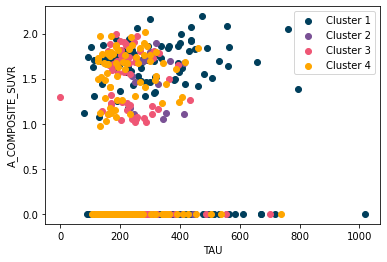

In [90]:
## KMEANS

## 4 Cluster
#X:{array-like, sparse matrix} of shape (n_samples, n_features)

kmeans2 = KMeans(n_clusters=4, random_state=None,max_iter=500,n_init=50).fit_predict(datanoage)


# columns to plot
col1=1
col2=3

color1='#003f5c'
color2='#7a5195'
color3='#ef5675'
color4='#ffa600'
#filter rows of original data
filtered_label0 = datanoage[kmeans2 == 0]
filtered_label1 = datanoage[kmeans2 == 1]
filtered_label2 = datanoage[kmeans2 == 2]
filtered_label3 = datanoage[kmeans2 == 3]
#plotting the results
plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)
plt.scatter(filtered_label3.iloc[:,col1] , filtered_label3.iloc[:,col2],label='Cluster 4',color=color4)



plt.xlabel(datanoage.columns[col1])
plt.ylabel(datanoage.columns[col2])

plt.legend()
plt.show()

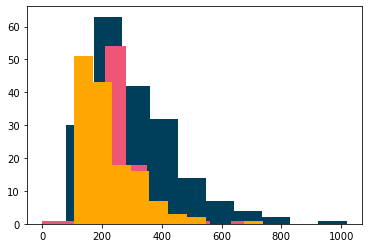

In [91]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)
plt.hist(filtered_label3.iloc[:,col1],label='Cluster 4',color=color4)
plt.show()

In [51]:
datanoage.columns

Index(['ABETA', 'TAU', 'PTAU', 'A_COMPOSITE_SUVR',
       'A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')

In [52]:
#3 clusters

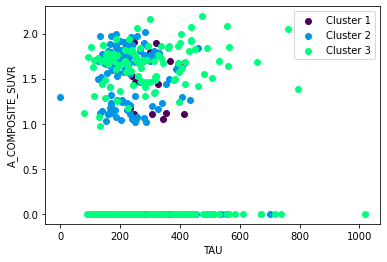

In [88]:
kmeans2 = KMeans(n_clusters=3, random_state=None,max_iter=500,n_init=50).fit_predict(datanoage)


#filter rows of original data
filtered_label0 = datanoage[kmeans2 == 0]
filtered_label1 = datanoage[kmeans2 == 1]
filtered_label2 = datanoage[kmeans2 == 2]

# columns to plot
col1=1
col2=3


color1='#4d005c'
color2='#0095e5'
color3='#00ff80'


#plotting the results
plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)



plt.xlabel(datanoage.columns[col1])
plt.ylabel(datanoage.columns[col2])
plt.legend()
plt.show()

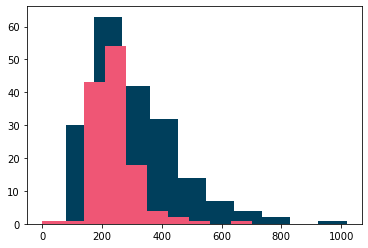

In [92]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)

plt.show()

In [14]:
filtered_label0 

,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
2,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
6,1061.0,408.7,30.82,0.0000,0.000000,0.000000,0.000000,0.000000,1.190137,1.178318,1.248440,1.417345,1.428345,0.961923,0.001881,0.000761,0.000682,0.002396
11,1007.0,155.6,12.81,1.7893,0.669591,0.583748,0.636897,0.616051,1.026279,0.927557,1.062317,1.097182,1.040814,1.037125,0.001976,0.000804,0.000854,0.003119
22,969.9,319.9,27.86,1.5246,0.762036,0.492457,0.603306,0.670405,1.279337,1.101441,1.388155,1.486495,1.247399,1.024619,0.001458,0.000482,0.000460,0.003668
27,920.9,253.8,26.99,1.7361,1.138644,0.725534,0.916940,0.780888,1.242776,1.022840,1.486097,1.547766,1.319464,1.067018,0.001767,0.000802,0.001130,0.003781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,1047.0,343.7,32.73,1.6684,0.836790,0.589367,0.735735,0.821326,1.354811,1.111575,1.410990,1.636962,1.614083,0.000000,0.002764,0.001150,0.001199,0.003988
485,1095.0,176.6,13.91,1.7728,0.724334,0.609262,0.682367,0.769968,1.088345,0.989368,1.120393,1.030579,1.130518,0.000000,0.002841,0.001265,0.001136,0.004146
486,1422.0,231.5,19.86,0.0000,0.000000,0.000000,0.000000,0.000000,1.177743,1.071711,1.165383,1.240425,1.269879,1.444825,0.002522,0.000903,0.001250,0.004186
487,1307.0,176.4,15.17,0.0000,0.000000,0.000000,0.000000,0.000000,1.138416,1.025719,1.048725,1.305480,1.325122,0.000000,0.002492,0.001225,0.001259,0.004262


In [ ]:
## 2 version, W AGE

In [69]:

dataage=pd.read_excel(datadir)
dataage=dataage[dataage.columns[dataage.columns.isin(['AGE','ABETA','PTAU','TAU','A_COMPOSITE_SUVR','A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'])]]
dataage[dataage < 0] = 0 #-99 set to 0
#X:{array-like, sparse matrix} of shape (n_samples, n_features)
print(dataage.columns)


Index(['AGE', 'ABETA', 'TAU', 'PTAU', 'A_COMPOSITE_SUVR',
       'A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'A_NORM_CTX_ENTORHINAL_SUVR',
       'A_NORM_AMYGDALA_SUVR', 'A_NORM_HIPPOCAMPUS_SUVR', 'T_COMPOSITE_SUVR',
       'T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR', 'T_NORM_CTX_ENTORHINAL_SUVR',
       'T_NORM_AMYGDALA_SUVR', 'T_NORM_HIPPOCAMPUS_SUVR', 'F_NORM_MEAN',
       'N_HIPPOCAMPUS_VOLUME', 'N_AMYGDALA_VOLUME', 'N_CTX_ENTORHINAL_VOLUME',
       'N_CTX_CAUDALMIDDLEFRONTAL_VOLUME'],
      dtype='object')


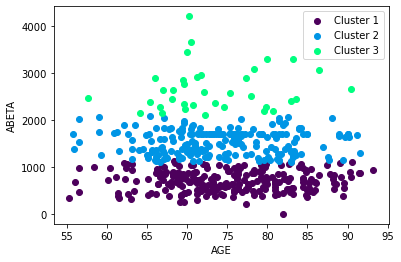

In [93]:

kmeans2 = KMeans(n_clusters=3, random_state=None,max_iter=500,n_init=50).fit_predict(dataage)
#filter rows of original data
filtered_label0 = dataage[kmeans2 == 0]
filtered_label1 = dataage[kmeans2 == 1]
filtered_label2 = dataage[kmeans2 == 2]

# columns to plot
col1=0
col2=1

color1='#4d005c'
color2='#0095e5'
color3='#00ff80'
#plotting the results
plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)


plt.xlabel(dataage.columns[col1])
plt.ylabel(dataage.columns[col2])

plt.legend()
plt.show()

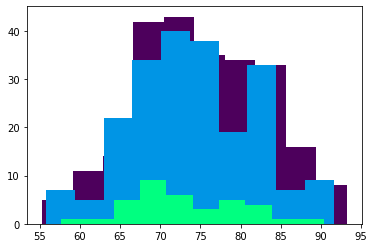

In [94]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)

plt.show()

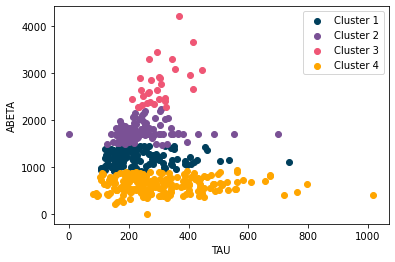

In [95]:

kmeans2 = KMeans(n_clusters=4, random_state=None,max_iter=500,n_init=50).fit_predict(dataage)
#filter rows of original data
filtered_label0 = dataage[kmeans2 == 0]
filtered_label1 = dataage[kmeans2 == 1]
filtered_label2 = dataage[kmeans2 == 2]
filtered_label3 = dataage[kmeans2 == 3]

# columns to plot
col1=2
col2=1

color1='#003f5c'
color2='#7a5195'
color3='#ef5675'
color4='#ffa600'
#plotting the results

plt.scatter(filtered_label0.iloc[:,col1] , filtered_label0.iloc[:,col2],label='Cluster 1',color=color1)
plt.scatter(filtered_label1.iloc[:,col1] , filtered_label1.iloc[:,col2],label='Cluster 2',color=color2)
plt.scatter(filtered_label2.iloc[:,col1] , filtered_label2.iloc[:,col2],label='Cluster 3',color=color3)
plt.scatter(filtered_label3.iloc[:,col1] , filtered_label3.iloc[:,col2],label='Cluster 4',color=color4)



plt.xlabel(dataage.columns[col1])
plt.ylabel(dataage.columns[col2])

plt.legend()
plt.show()

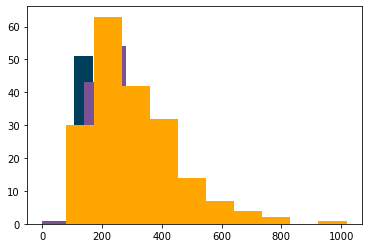

In [96]:
plt.hist(filtered_label0.iloc[:,col1],label='Cluster 1',color=color1)
plt.hist(filtered_label1.iloc[:,col1],label='Cluster 2',color=color2)
plt.hist(filtered_label2.iloc[:,col1],label='Cluster 3',color=color3)
plt.hist(filtered_label3.iloc[:,col1],label='Cluster 4',color=color4)
plt.show()

In [66]:
filtered_label0

,AGE,ABETA,TAU,PTAU,A_COMPOSITE_SUVR,A_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,A_NORM_CTX_ENTORHINAL_SUVR,A_NORM_AMYGDALA_SUVR,A_NORM_HIPPOCAMPUS_SUVR,T_COMPOSITE_SUVR,T_NORM_CTX_CAUDALMIDDLEFRONTAL_SUVR,T_NORM_CTX_ENTORHINAL_SUVR,T_NORM_AMYGDALA_SUVR,T_NORM_HIPPOCAMPUS_SUVR,F_NORM_MEAN,N_HIPPOCAMPUS_VOLUME,N_AMYGDALA_VOLUME,N_CTX_ENTORHINAL_VOLUME,N_CTX_CAUDALMIDDLEFRONTAL_VOLUME
2,78.0,1286.0,186.9,14.14,1.8474,0.667858,0.642308,0.636949,0.639710,1.240267,1.079087,1.219323,1.296168,1.356808,1.144017,0.001863,0.001093,0.001091,0.004246
6,79.8,1061.0,408.7,30.82,0.0000,0.000000,0.000000,0.000000,0.000000,1.190137,1.178318,1.248440,1.417345,1.428345,0.961923,0.001881,0.000761,0.000682,0.002396
11,74.9,1007.0,155.6,12.81,1.7893,0.669591,0.583748,0.636897,0.616051,1.026279,0.927557,1.062317,1.097182,1.040814,1.037125,0.001976,0.000804,0.000854,0.003119
22,60.4,969.9,319.9,27.86,1.5246,0.762036,0.492457,0.603306,0.670405,1.279337,1.101441,1.388155,1.486495,1.247399,1.024619,0.001458,0.000482,0.000460,0.003668
27,75.1,920.9,253.8,26.99,1.7361,1.138644,0.725534,0.916940,0.780888,1.242776,1.022840,1.486097,1.547766,1.319464,1.067018,0.001767,0.000802,0.001130,0.003781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,70.5,1047.0,343.7,32.73,1.6684,0.836790,0.589367,0.735735,0.821326,1.354811,1.111575,1.410990,1.636962,1.614083,0.000000,0.002764,0.001150,0.001199,0.003988
485,62.1,1095.0,176.6,13.91,1.7728,0.724334,0.609262,0.682367,0.769968,1.088345,0.989368,1.120393,1.030579,1.130518,0.000000,0.002841,0.001265,0.001136,0.004146
486,71.0,1422.0,231.5,19.86,0.0000,0.000000,0.000000,0.000000,0.000000,1.177743,1.071711,1.165383,1.240425,1.269879,1.444825,0.002522,0.000903,0.001250,0.004186
487,75.1,1307.0,176.4,15.17,0.0000,0.000000,0.000000,0.000000,0.000000,1.138416,1.025719,1.048725,1.305480,1.325122,0.000000,0.002492,0.001225,0.001259,0.004262
